# Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dropout, Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import mnist
import pandas as pd
from keras.utils import to_categorical
from PIL import Image
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data
1. Applied rescaling to images.
2. We have less data for task, but still considering that the task is less complex maybe it would work just fine.
3. We have 62 classes.
4. Seed  = 42 so that same results on every run
5. Going for initial try with 256*256 images with batch size = 64 (Randomly Seleted)
6. Validatiuon split = 0.1, batch size = 32 for first try but i think size is too small
7. Trying Validsation_Split = 0.2

In [105]:
train_datagen = ImageDataGenerator(
                                    rescale =1/255,
                                    validation_split = 0.2
                                  )
train = train_datagen.flow_from_directory(
                                          'train',
                                           target_size = (28, 28),
                                           batch_size = 64,
                                           class_mode = "categorical",
                                           seed = 42,
                                           subset = 'training'
                                         )
valid = train = train_datagen.flow_from_directory(
                                          'train',
                                           target_size = (28, 28),
                                           batch_size = 32,
                                           class_mode = "categorical",
                                           seed = 42,
                                           subset = 'validation'
                                         )

Found 1984 images belonging to 62 classes.
Found 496 images belonging to 62 classes.


# Checking for BASELINE accuracy on a simpler model

1. Made this to test the behaviour on a much simpler dataset consisting of 1 Conv2D, and 2 Dense layers.
2. Making checkpoints i.e. saving weights according to the change in val_accuracy.
3. The accuracy and loss curve plotted in end shopws everything is okay.
4. Used loss = categorical_crossentropy beacuse our case consists of multiple output classes
5. Used Adam optimizer beacuse changes learning rate per epoch and hence better convergence

In [2]:
def baseline_model():
# create model
    model = keras.Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(28, 28,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(62, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [108]:
checkpoint = ModelCheckpoint(
    'working/weights_baseline-{epoch:02d}-{val_accuracy:.2f}.hdf5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    period = 1)
model = baseline_model()
model.summary()
history = model.fit(train, validation_data = valid, epochs = 20, verbose = 1, callbacks = [checkpoint])

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 24, 24, 32)        2432      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_59 (Dense)             (None, 128)               589952    
_________________________________________________________________
dense_60 (Dense)             (None, 62)                7998      
Total params: 600,382
Trainable params: 600,382
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
16/16 [==============================] - 10s 645ms/step - loss: 4.2220 - accuracy: 0.0224 - val_loss: 

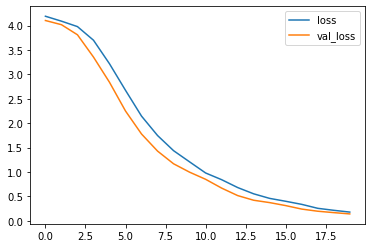

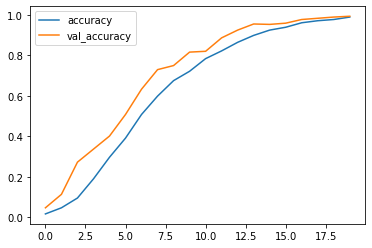

In [109]:
plot_b = pd.DataFrame(history.history)
plot_b.loc[:,["loss", "val_loss"]].plot();
plot_b.loc[:,["accuracy", "val_accuracy"]].plot();

# best weights for baseline model - working/weights_baseline-20-0.99.hdf5

In [3]:
def larger_model(weights = 'softmax'):
    # create model
    model = keras.Sequential()
    model.add(Conv2D(28, (5, 5), input_shape = (28, 28, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(62, activation = weights))
    return model

In [115]:
model_l = larger_model()
# Compile model
model_l.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
checkpoint_l = ModelCheckpoint(
    'working/weights_largerModel-{epoch:02d}-{val_accuracy:.2f}.hdf5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    period = 1)
history_l = model_l.fit(train, validation_data = valid, epochs = 50, verbose = 2, callbacks = [checkpoint_l])

Epoch 1/50
16/16 - 10s - loss: 4.1525 - accuracy: 0.0121 - val_loss: 4.1255 - val_accuracy: 0.0222

Epoch 00001: val_accuracy improved from -inf to 0.02218, saving model to working/weights_largerModel-01-0.02.hdf5
Epoch 2/50
16/16 - 9s - loss: 4.1267 - accuracy: 0.0121 - val_loss: 4.1216 - val_accuracy: 0.0242

Epoch 00002: val_accuracy improved from 0.02218 to 0.02419, saving model to working/weights_largerModel-02-0.02.hdf5
Epoch 3/50
16/16 - 9s - loss: 4.1274 - accuracy: 0.0181 - val_loss: 4.1184 - val_accuracy: 0.0282

Epoch 00003: val_accuracy improved from 0.02419 to 0.02823, saving model to working/weights_largerModel-03-0.03.hdf5
Epoch 4/50
16/16 - 9s - loss: 4.1155 - accuracy: 0.0363 - val_loss: 4.0869 - val_accuracy: 0.0524

Epoch 00004: val_accuracy improved from 0.02823 to 0.05242, saving model to working/weights_largerModel-04-0.05.hdf5
Epoch 5/50
16/16 - 9s - loss: 4.0847 - accuracy: 0.0363 - val_loss: 4.0206 - val_accuracy: 0.0867

Epoch 00005: val_accuracy improved from


Epoch 00042: val_accuracy did not improve from 1.00000
Epoch 43/50
16/16 - 10s - loss: 0.1353 - accuracy: 0.9597 - val_loss: 0.0279 - val_accuracy: 0.9940

Epoch 00043: val_accuracy did not improve from 1.00000
Epoch 44/50
16/16 - 10s - loss: 0.1591 - accuracy: 0.9577 - val_loss: 0.0176 - val_accuracy: 0.9980

Epoch 00044: val_accuracy did not improve from 1.00000
Epoch 45/50
16/16 - 9s - loss: 0.0997 - accuracy: 0.9798 - val_loss: 0.0134 - val_accuracy: 0.9980

Epoch 00045: val_accuracy did not improve from 1.00000
Epoch 46/50
16/16 - 10s - loss: 0.0888 - accuracy: 0.9718 - val_loss: 0.0094 - val_accuracy: 1.0000

Epoch 00046: val_accuracy did not improve from 1.00000
Epoch 47/50
16/16 - 10s - loss: 0.1132 - accuracy: 0.9657 - val_loss: 0.0328 - val_accuracy: 0.9980

Epoch 00047: val_accuracy did not improve from 1.00000
Epoch 48/50
16/16 - 10s - loss: 0.1432 - accuracy: 0.9536 - val_loss: 0.0176 - val_accuracy: 0.9980

Epoch 00048: val_accuracy did not improve from 1.00000
Epoch 49/

In [123]:
model_l.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 24, 24, 30)        780       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 12, 12, 30)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 10, 10, 15)        4065      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 5, 5, 15)          0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 5, 5, 15)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 375)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 1024)            

# best weights - working/weights_largerModel-33-1.00.hdf5

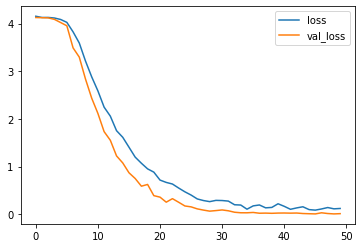

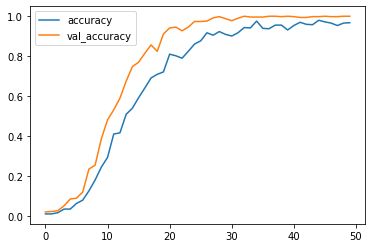

In [117]:
plot_l = pd.DataFrame(history_l.history)
plot_l.loc[:,["loss", "val_loss"]].plot();
plot_l.loc[:,["accuracy", "val_accuracy"]].plot();

# Task 2

# Load MNIST Dataset and setting up a local copy too
1. Downloaded 4 files as said and pklaced in input directory
2. Used the following code to load the given MNIST dataset from downloaded ubyte file
3. Converted the loaded images from list to numpy array, and then wrote the script to save the local copy of images in the respective mnist and mnist_t directory for train and test respectively.

In [122]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

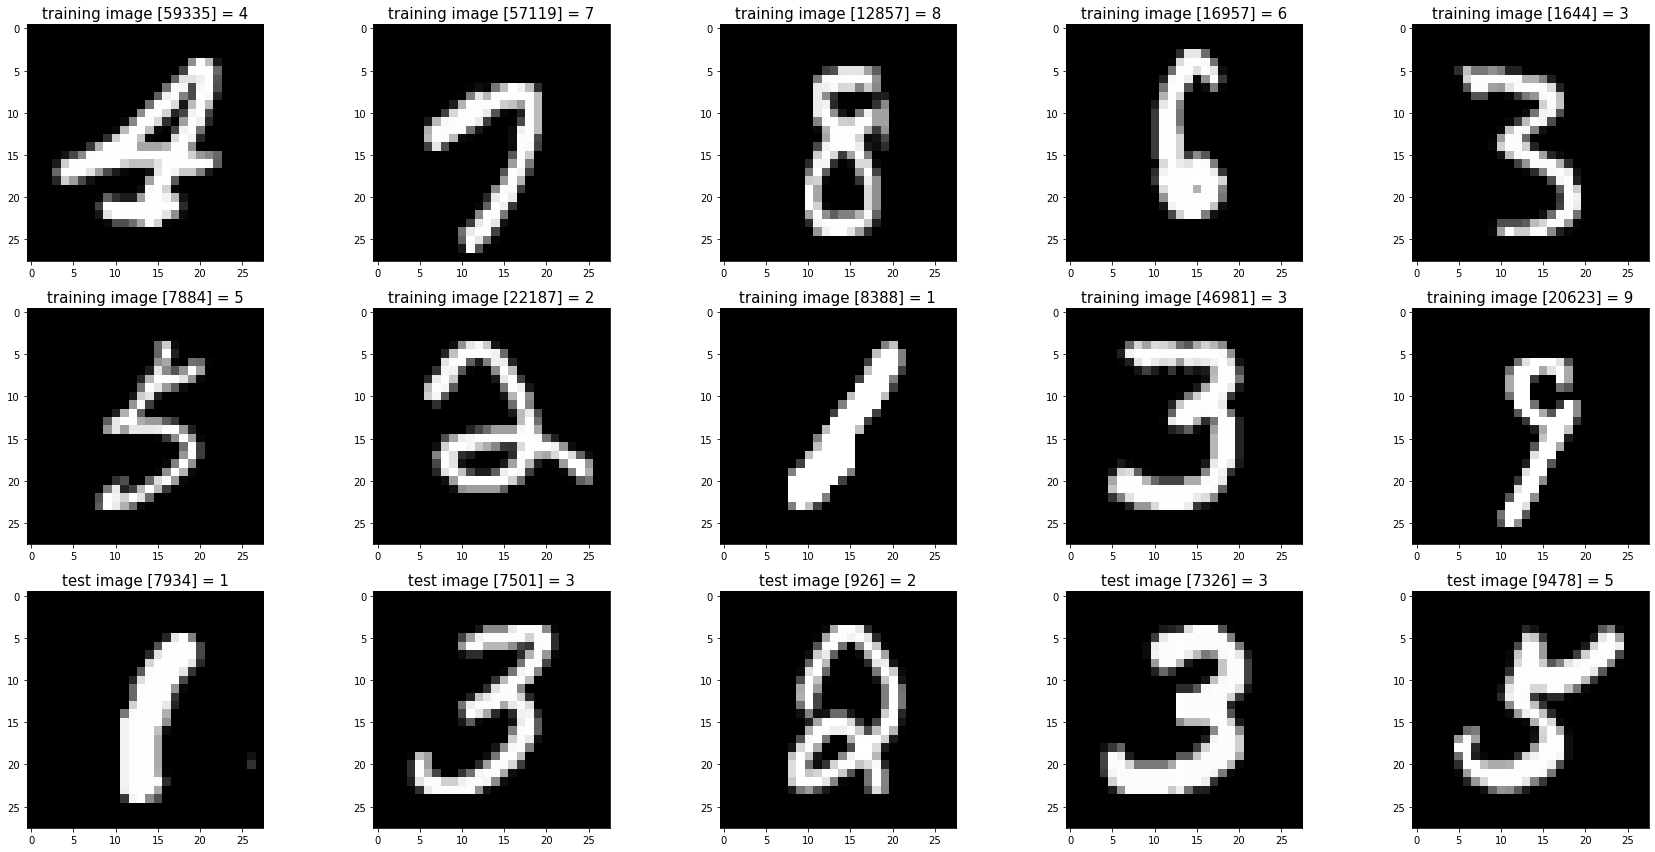

In [123]:
# Verify Reading Dataset via MnistDataloader class
# Set file paths based on added MNIST Datasets
#
input_path = 'input/'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [35]:
x_train = np.array(x_train)#/255
x_test = np.array(x_test)#/255
y_train = np.array(y_train)#/255
y_test = np.array(y_test)#/255

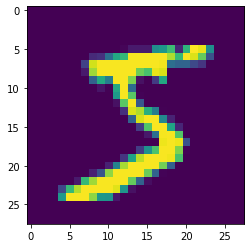

In [124]:
plt.imshow(x_train[0])

## Making local copy in form of images
NOTE: Uncomment to run if you want to

In [125]:
# mkdir mnist

In [51]:
# cd mnist

/home/kapie/MIDAS_Task/mnist


In [59]:
# mkdir 0 1 2 3 4 5 6 7 8 9

In [50]:
# cd ..

/home/kapie/MIDAS_Task


In [45]:
# mkdir mnist_t

In [46]:
# cd mnist_t

/home/kapie/MIDAS_Task/mnist_t


In [47]:
# mkdir 0 1 2 3 4 5 6 7 8 9

In [61]:
# for i in range(len(x_train)):
#     im = Image.fromarray(x_train[i])
#     im.save('{j}/train_{i}.png'.format(j = y_train[i], i = i))

In [67]:
# cd ..

/home/kapie/MIDAS_Task


In [63]:
# cd mnist_t

/home/kapie/MIDAS_Task/mnist_t


In [71]:
# for i in range(len(x_test)):
#     im = Image.fromarray(x_test[i])
#     im.save('{j}/train_{i}.png'.format(j = y_test[i], i = i))

# Using pretrained model on loaded MNIST
1. USING similar dfataset loading methods as before
2. Using larger model but also introduced dense layer as now we only have 10 classes
3. Loaded the best weights for our pretrained larger_model
4. For once freezed the pretrained model then trained and then trained in unfreezed pretrained model

In [11]:
train_datagen = ImageDataGenerator(
                                    rescale =1/255,
                                    validation_split = 0.2
                                  )
train_p = train_datagen.flow_from_directory(
                                          'mnist/',
                                           target_size = (28, 28),
                                           batch_size = 64,
                                           class_mode = "categorical",
                                           seed = 42,
                                           subset = 'training'
                                         )
valid_p = train = train_datagen.flow_from_directory(
                                          'mnist/',
                                           target_size = (28, 28),
                                           batch_size = 32,
                                           class_mode = "categorical",
                                           seed = 42,
                                           subset = 'validation'
                                         )
test_datagen = ImageDataGenerator(
                                    rescale =1/255,
                                 )
test_p = test_datagen.flow_from_directory(
                                          'mnist_t/',
                                           target_size = (28, 28),
                                           batch_size = 32,
                                           class_mode = "categorical",
                                           seed = 42,
                                         )

Found 48004 images belonging to 10 classes.
Found 11996 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [127]:
model_p = larger_model('relu')
model_p.load_weights("working/weights_largerModel-33-1.00.hdf5")
model_p.add(Dense(10, "softmax"))

Freezed

In [128]:
for layers in model_p.layers[: -1]:
    layers.trainable = False

In [130]:
model_p.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [131]:
checkpoint_p = ModelCheckpoint(
    'working/weights_pretrainedModel-{epoch:02d}-{val_accuracy:.2f}.hdf5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    period = 1)
model_p.summary()
history_p = model_p.fit(train_p, validation_data = valid_p, epochs = 50, verbose = 1, callbacks = [checkpoint_p])

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 24, 24, 28)        2128      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 12, 12, 28)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 10, 10, 16)        4048      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 400)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 1024)            

751/751 [==============================] - 11s 14ms/step - loss: 1.1123 - accuracy: 0.6232 - val_loss: 0.9326 - val_accuracy: 0.7007

Epoch 00027: val_accuracy did not improve from 0.70190
Epoch 28/50
751/751 [==============================] - 10s 14ms/step - loss: 1.1191 - accuracy: 0.6225 - val_loss: 0.9315 - val_accuracy: 0.7013

Epoch 00028: val_accuracy did not improve from 0.70190
Epoch 29/50
751/751 [==============================] - 10s 14ms/step - loss: 1.1109 - accuracy: 0.6218 - val_loss: 0.9309 - val_accuracy: 0.7010

Epoch 00029: val_accuracy did not improve from 0.70190
Epoch 30/50
751/751 [==============================] - 11s 14ms/step - loss: 1.1187 - accuracy: 0.6165 - val_loss: 0.9307 - val_accuracy: 0.7017

Epoch 00030: val_accuracy did not improve from 0.70190
Epoch 31/50
751/751 [==============================] - 10s 14ms/step - loss: 1.1186 - accuracy: 0.6226 - val_loss: 0.9316 - val_accuracy: 0.6995

Epoch 00031: val_accuracy did not improve from 0.70190
Epoch 3

# Best Weights - working/weights_pretrainedModel-43-0.70.hdf5
### Validation Accuracy = 0.70

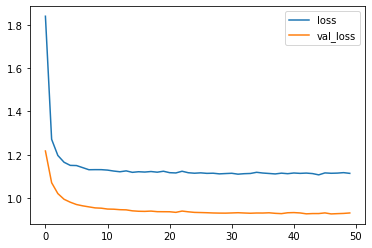

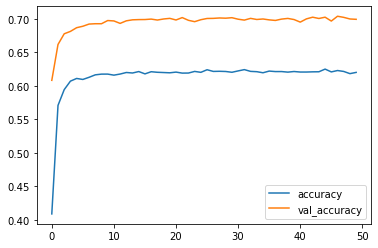

In [132]:
plot_p = pd.DataFrame(history_p.history)
plot_p.loc[:,["loss", "val_loss"]].plot();
plot_p.loc[:,["accuracy", "val_accuracy"]].plot();

converged at before 8 epochs
### Not quite good lets try finetuning the pre trained model by unfreezing the layers

# NOW unfreezed pretrained model

In [133]:
model_pu = larger_model('relu')
model_pu.load_weights("working/weights_largerModel-33-1.00.hdf5")
model_pu.add(Dense(10, "softmax"))

Unfreezed

In [134]:
model_pu.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [135]:
checkpoint_pu = ModelCheckpoint(
    'working/weights_pretrainedModel-{epoch:02d}-{val_accuracy:.2f}.hdf5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    period = 1)
model_pu.summary()
history_pu = model_pu.fit(train_p, validation_data = valid_p, epochs = 50, verbose = 1, callbacks = [checkpoint_pu])

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 24, 24, 28)        2128      
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 12, 12, 28)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 10, 10, 16)        4048      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 5, 5, 16)          0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 400)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 1024)            


Epoch 00030: val_accuracy did not improve from 0.99250
Epoch 31/50
751/751 [==============================] - 11s 14ms/step - loss: 0.0127 - accuracy: 0.9967 - val_loss: 0.0388 - val_accuracy: 0.9918

Epoch 00031: val_accuracy did not improve from 0.99250
Epoch 32/50
751/751 [==============================] - 11s 14ms/step - loss: 0.0102 - accuracy: 0.9970 - val_loss: 0.0336 - val_accuracy: 0.9930

Epoch 00032: val_accuracy improved from 0.99250 to 0.99300, saving model to working/weights_pretrainedModel-32-0.99.hdf5
Epoch 33/50
751/751 [==============================] - 11s 14ms/step - loss: 0.0089 - accuracy: 0.9978 - val_loss: 0.0631 - val_accuracy: 0.9906

Epoch 00033: val_accuracy did not improve from 0.99300
Epoch 34/50
751/751 [==============================] - 11s 15ms/step - loss: 0.0150 - accuracy: 0.9962 - val_loss: 0.0575 - val_accuracy: 0.9899

Epoch 00034: val_accuracy did not improve from 0.99300
Epoch 35/50
751/751 [==============================] - 12s 16ms/step - los

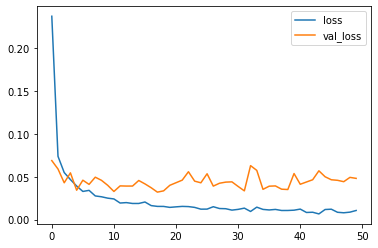

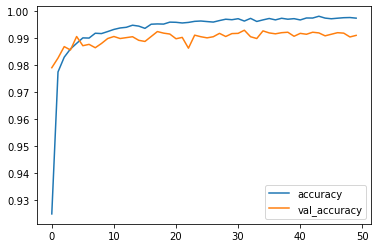

In [137]:
plot_pu = pd.DataFrame(history_pu.history)
plot_pu.loc[:,["loss", "val_loss"]].plot();
plot_pu.loc[:,["accuracy", "val_accuracy"]].plot();

# Best Weights - working/weights_pretrainedModel-32-0.99.hdf5

# Results for unfreezed pretrained model
### Model seems to ahive convergence within first 3 epochs and accuracy for validation is about 0.99 which is much better than Freezed pretrained model.

# Now trying randomly initialized weights without loading pretrained weights

In [5]:
model_r = larger_model('relu')
model_r.add(Dense(10, "softmax"))

Randomly Initialized

In [6]:
model_r.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
checkpoint_r = ModelCheckpoint(
    'working/weights_task2randominitialized-{epoch:02d}-{val_accuracy:.2f}.hdf5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    period = 1)
model_r.summary()
history_r = model_r.fit(train_p, validation_data = valid_p, epochs = 50, verbose = 1, callbacks = [checkpoint_r])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 28)        2128      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 28)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        4048      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              4

751/751 [==============================] - 12s 16ms/step - loss: 0.0135 - accuracy: 0.9963 - val_loss: 0.0441 - val_accuracy: 0.9907

Epoch 00029: val_accuracy did not improve from 0.99250
Epoch 30/50
751/751 [==============================] - 12s 16ms/step - loss: 0.0108 - accuracy: 0.9975 - val_loss: 0.0460 - val_accuracy: 0.9905

Epoch 00030: val_accuracy did not improve from 0.99250
Epoch 31/50
751/751 [==============================] - 11s 15ms/step - loss: 0.0119 - accuracy: 0.9970 - val_loss: 0.0368 - val_accuracy: 0.9932

Epoch 00031: val_accuracy improved from 0.99250 to 0.99325, saving model to working/weights_task2randominitialized-31-0.99.hdf5
Epoch 32/50
751/751 [==============================] - 11s 15ms/step - loss: 0.0121 - accuracy: 0.9969 - val_loss: 0.0493 - val_accuracy: 0.9913

Epoch 00032: val_accuracy did not improve from 0.99325
Epoch 33/50
751/751 [==============================] - 11s 15ms/step - loss: 0.0110 - accuracy: 0.9965 - val_loss: 0.0447 - val_accurac

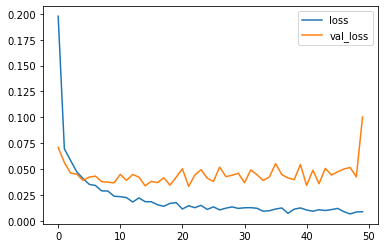

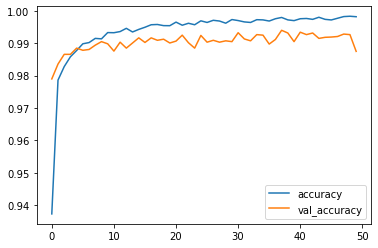

In [9]:
plot_r = pd.DataFrame(history_r.history)
plot_r.loc[:,["loss", "val_loss"]].plot();
plot_r.loc[:,["accuracy", "val_accuracy"]].plot();

# Results for Randomly Initialized Model
### Model seems to achive convergence within first 9 epochs and accuracy for validation is about 0.99
### But it seems that randomly initialized model takes a bit more epochs for converging to an optimal solution

In [ ]:
99
### But it seems that randomly initialized model takes a bit more epochs for converging toan opt

# Task 3

In [17]:
train_datagen = ImageDataGenerator(
                                    rescale =1/255,
                                    validation_split = 0.2
                                  )
train_p3 = train_datagen.flow_from_directory(
                                          'mnistTask3/',
                                           target_size = (28, 28),
                                           batch_size = 64,
                                           class_mode = "categorical",
                                           seed = 42,
                                           subset = 'training'
                                         )
valid_p3 = train = train_datagen.flow_from_directory(
                                          'mnistTask3/',
                                           target_size = (28, 28),
                                           batch_size = 32,
                                           class_mode = "categorical",
                                           seed = 42,
                                           subset = 'validation'
                                         )

Found 48006 images belonging to 10 classes.
Found 11994 images belonging to 10 classes.


# NOW unfreezed pretrained model

In [18]:
model_pu3 = larger_model('relu')
model_pu3.load_weights("working/weights_largerModel-33-1.00.hdf5")
model_pu3.add(Dense(10, "softmax"))

Unfreezed

In [19]:
model_pu3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
checkpoint_pu3 = ModelCheckpoint(
    'working/weights_pretrainedModelTask3-{epoch:02d}-{val_accuracy:.2f}.hdf5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    period = 1)
model_pu3.summary()
history_pu3 = model_pu3.fit(train_p3, validation_data = valid_p3, epochs = 50, verbose = 1, callbacks = [checkpoint_pu3])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 28)        2128      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 28)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 16)        4048      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)             

751/751 [==============================] - 12s 16ms/step - loss: 1.7720 - accuracy: 0.3286 - val_loss: 2.6177 - val_accuracy: 0.1101

Epoch 00030: val_accuracy did not improve from 0.11556
Epoch 31/50
751/751 [==============================] - 12s 15ms/step - loss: 1.7291 - accuracy: 0.3485 - val_loss: 2.6631 - val_accuracy: 0.1073

Epoch 00031: val_accuracy did not improve from 0.11556
Epoch 32/50
751/751 [==============================] - 15s 20ms/step - loss: 1.6943 - accuracy: 0.3617 - val_loss: 2.6618 - val_accuracy: 0.1102

Epoch 00032: val_accuracy did not improve from 0.11556
Epoch 33/50
751/751 [==============================] - 13s 17ms/step - loss: 1.6583 - accuracy: 0.3767 - val_loss: 2.7041 - val_accuracy: 0.1090

Epoch 00033: val_accuracy did not improve from 0.11556
Epoch 34/50
751/751 [==============================] - 13s 17ms/step - loss: 1.6237 - accuracy: 0.3933 - val_loss: 2.7621 - val_accuracy: 0.1141

Epoch 00034: val_accuracy did not improve from 0.11556
Epoch 3

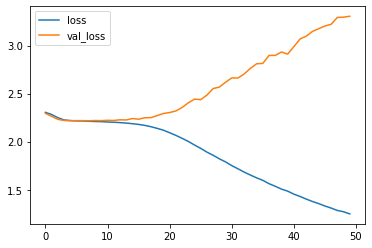

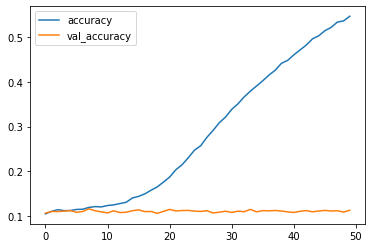

In [21]:
plot_pu3 = pd.DataFrame(history_pu3.history)
plot_pu3.loc[:,["loss", "val_loss"]].plot();
plot_pu3.loc[:,["accuracy", "val_accuracy"]].plot();

### Evaluating Task 2 generated as asked test set on standerd test split of MNIST dataset

In [29]:
results_up_task3 = model_pu3.evaluate(test_p, batch_size=128)
print("test loss, test acc:", results_up_task3)

313/313 [==============================] - 2s 7ms/step - loss: 9.3102 - accuracy: 0.0033
test loss, test acc: [9.310237884521484, 0.0032999999821186066]


# Best Weights - working/weights_pretrainedModelTask3-08-0.12.hdf5

# Results for unfreezed pretrained model
### Model somehow seems not to be training and instead trying to overfit the training split. Moreover, from around 15 epochs val_loss starts increasing while trraining loss is still decreasing hence proving that the model is overfitting the training split. Also, we have best val_accuracy of only 0.12. And test accuracy even less.

# Now trying randomly initialized weights without loading pretrained weights

In [22]:
model_r3 = larger_model('relu')
model_r3.add(Dense(10, "softmax"))

Randomly Initialized

In [23]:
model_r3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
checkpoint_r3 = ModelCheckpoint(
    'working/weights_Task3randominitialized-{epoch:02d}-{val_accuracy:.2f}.hdf5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max',
    period = 1)
model_r3.summary()
history_r3 = model_r3.fit(train_p3, validation_data = valid_p3, epochs = 50, verbose = 1, callbacks = [checkpoint_r3])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 24, 24, 28)        2128      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 28)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 16)        4048      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)             


Epoch 00029: val_accuracy did not improve from 0.11572
Epoch 30/50
751/751 [==============================] - 13s 17ms/step - loss: 1.5739 - accuracy: 0.4212 - val_loss: 2.8263 - val_accuracy: 0.1164

Epoch 00030: val_accuracy improved from 0.11572 to 0.11639, saving model to working/weights_Task3randominitialized-30-0.12.hdf5
Epoch 31/50
751/751 [==============================] - 13s 17ms/step - loss: 1.5381 - accuracy: 0.4385 - val_loss: 2.9491 - val_accuracy: 0.1116

Epoch 00031: val_accuracy did not improve from 0.11639
Epoch 32/50
751/751 [==============================] - 13s 17ms/step - loss: 1.5036 - accuracy: 0.4499 - val_loss: 2.9987 - val_accuracy: 0.1111

Epoch 00032: val_accuracy did not improve from 0.11639
Epoch 33/50
751/751 [==============================] - 12s 17ms/step - loss: 1.4646 - accuracy: 0.4618 - val_loss: 2.9509 - val_accuracy: 0.1145

Epoch 00033: val_accuracy did not improve from 0.11639
Epoch 34/50
751/751 [==============================] - 12s 17ms/ste

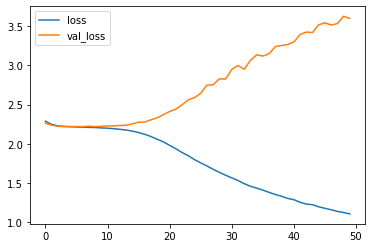

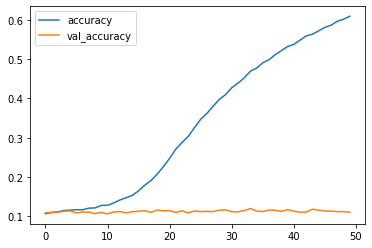

In [25]:
plot_r3 = pd.DataFrame(history_r3.history)
plot_r3.loc[:,["loss", "val_loss"]].plot();
plot_r3.loc[:,["accuracy", "val_accuracy"]].plot();

# Best Weights - working/weights_Task3randominitialized-34-0.12.hdf5

# Results for Randomly Initialized Model
### Model somehow seems not to be training and instead trying to overfit the training split. Moreover, from around 15 epochs val_loss starts increasing while trraining loss is still decreasing hence proving that the model is overfitting the training split. Also, we have best val_accuracy of only 0.12. And test accuracy even less.

### Evaluating Task 2 generated as asked test set on standerd test split of MNIST dataset

In [28]:
results_ri_task3 = model_r3.evaluate(test_p, batch_size=128)
print("test loss, test acc:", results_ri_task3)

313/313 [==============================] - 5s 15ms/step - loss: 11.1126 - accuracy: 0.0045
test loss, test acc: [11.112616539001465, 0.0044999998062849045]
